In [ ]:
!pip install rdkit-pypi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 48.9 MB/s eta 0:00:00


In [ ]:
!pip install Augmentor

In [ ]:
!mkdir original_data

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import Augmentor
import numpy as np

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization, Dropout
from keras.models import Model

from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D

import os

In [ ]:
img_size = [128, 128]
batch_size = 32

In [ ]:
molecules_smiles = [
    'CCBr', 'CCCl', 'CC(C)(C)CC(C)C',
    'CBr', 'CC=CCC(C)C', 'CC(C)=CC(C)C',
    'CCBr', 'CC#CCC(C)C', 'CC(C)CC#CC',
    'CCl', 'CCC(=O)OC', 'CC(=O)N', 'CCC(=O)N(C)C', 'CC(=O)C(C)C', 'CC(Cl)Cl',
    'O=S(=O)(O)O', 'O=[Ti](O)O', 'OS(=O)(=O)O', 'OP(=O)(O)O', 'OP(=O)(O)S', 'O=[Si](O)(O)O',
    'CC(C)(C)O', 'CC(C)(C)OC(C)C', 'CC(C)(C)OCC(C)C',
    'c1ccccc1C(=O)O', 'c1ccccc1N=C=S', 'c1ccc(cc1)C=O', 'c1ccccc1OC(C)C', 'c1ccccc1OCCN', 'c1ccc(cc1)C(C)(C)C',
    'C(=O)O', 'CC(=O)O', 'O=C(O)C=C', 'O=Cl(=O)(=O)O', 'O=[As](O)O', 'I(Cl)Cl',
    'CI', 'CCI', 'CI(=O)=O',
    'CC(=O)CC(C)C', 'CC(Cl)(Cl)Cl', 'C(=O)CC(C)C',
    'C(Br)(Br)Br', 'C(=O)N(C)C', 'CC(=O)OC(C)C',
    'CC(C)N', 'CC(C)NC(C)C', 'CC(C)N(C)C',
    'CC(=O)N(C)C', 'CCC(=O)N(C)C'
]

opts = Draw.MolDrawOptions()
opts.bondLineWidth = 10
opts.fontBold = True
opts.minFontSize = 30
opts.fontScale = 5

for i, smiles in enumerate(molecules_smiles):
    mol = Chem.MolFromSmiles(smiles)

    # Check if the molecule is valid
    if mol is None:
        print(f"Invalid SMILES for molecule {i + 1}: {smiles}")
        continue

    img = Draw.MolToImage(mol, size = (img_size[0], img_size[1]), kekulize=False, wedgeBonds=False, options=opts)

    img_path = f'original_data/molecule_{i + 1}.png'

    img.save(img_path)

In [ ]:
files = os.listdir('original_data/')

files = [file for file in files if file.lower().endswith('.png')]

images = []

for png_file in files:
    image_path = os.path.join("original_data/", png_file)
    img = Image.open(image_path)
    images.append(img)

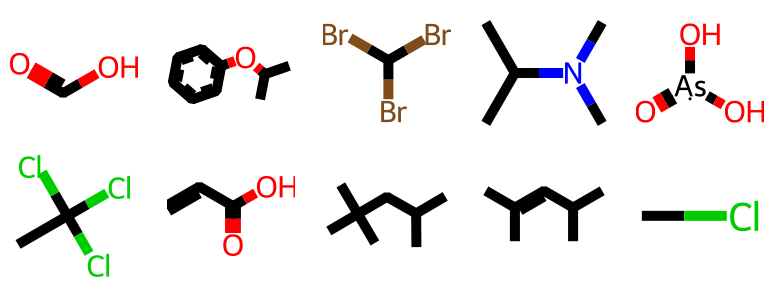

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (8, 3))

for i in range(10):
    img = images[i]
    ax = axes[i // 5, i % 5]
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
pipeline = Augmentor.Pipeline('original_data', output_directory = 'augmented_data')

pipeline.rotate(probability = 0.95, max_left_rotation = 10, max_right_rotation = 10)
pipeline.zoom_random(probability = 0.95, percentage_area = 0.9)

pipeline.sample(1050)

Initialised with 50 image(s) found.
Output directory set to original_data/augmented_data.

Processing <PIL.Image.Image image mode=RGB size=128x128 at 0x7BD6705D7FD0>: 100%|██████████| 1050/1050 [00:11<00:00, 92.18 Samples/s] 


In [ ]:
augmented_dir = 'original_data/augmented_data'

files = [file for file in os.listdir(augmented_dir) if file.lower().endswith('.png')]

for png_file in files:
    image_path = os.path.join(augmented_dir, png_file)
    img = Image.open(image_path)
    images.append(img)

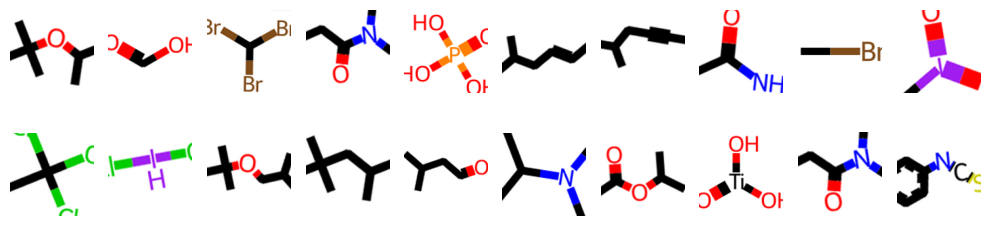

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 10, figsize = (10, 3))

for i in range(500, 520):
    pil_image = images[i]
    ax = axes[(i - 500) // 10, (i - 500) % 10]
    ax.imshow(pil_image)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# !rm -R original_data

In [ ]:
X_train, X_test = train_test_split(images, train_size = 0.8, random_state = 42)

X_train = [i.convert('L') for i in X_train]
X_train = np.array([np.array(i) for i in X_train])
X_train = X_train / 255.0
X_train = np.reshape(X_train, (len(X_train), img_size[0], img_size[1], 1))

X_test = [i.convert('L') for i in X_test]
X_test = np.array([np.array(i) for i in X_test])
X_test = X_test / 255.0
X_test = np.reshape(X_test, (len(X_test), img_size[0], img_size[1], 1))

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)

In [ ]:
def show_resualts(autoencoder, X_test):
    n = 10

    imgs = X_test[:n]
    decoded_imgs = autoencoder.predict(X_test[:n], batch_size = n)

    plt.figure(figsize = (n, 2))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(imgs[i].squeeze(), cmap = 'gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax2 = plt.subplot(2, n, i + n + 1)
        plt.imshow(decoded_imgs[i].squeeze(), cmap = 'gray')
        ax2.get_xaxis().set_visible(False)
        ax2.get_yaxis().set_visible(False)

    plt.show()


def show_history(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(train_loss) + 1)
    plt.plot(epochs, train_loss, label = 'Training Loss')
    plt.plot(epochs, val_loss, label = 'Validation Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
def show_RGBresualts(autoencoder, X_test):
    n = 10

    imgs = X_test[:n]
    decoded_imgs = autoencoder.predict(X_test[:n], batch_size = n)

    plt.figure(figsize = (n, 2))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(imgs[i].squeeze())
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax2 = plt.subplot(2, n, i + n + 1)
        plt.imshow(decoded_imgs[i].squeeze())
        ax2.get_xaxis().set_visible(False)
        ax2.get_yaxis().set_visible(False)

    plt.show()


In [ ]:
input_img = Input((img_size[0], img_size[1], 1))
x = Flatten()(input_img)
x = Dense(512, activation = 'relu')(x)
x = Dense(256, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
encoded = Dense(512, activation = 'relu')(x)

d = Dense(128, activation = 'relu')(encoded)
d = Dense(256, activation = 'relu')(d)
d = Dense(512, activation = 'relu')(d)
d = Dense(img_size[0] * img_size[1], activation = 'sigmoid')(d)
decoded = Reshape((img_size[0], img_size[1], 1))(d)

autoencoder = keras.Model(input_img, decoded, name = "autoencoder")
autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error')


In [ ]:
history = autoencoder.fit(X_train, X_train,
                epochs = 50,
                batch_size = batch_size,
                validation_data = (X_test, X_test),
                shuffle = True,
                callbacks = [early_stopping])

Epoch 1/50
28/28 [==============================] - 13s 368ms/step - loss: 0.1176 - val_loss: 0.0871
Epoch 2/50
28/28 [==============================] - 11s 391ms/step - loss: 0.0881 - val_loss: 0.0877
Epoch 3/50
28/28 [==============================] - 11s 394ms/step - loss: 0.0876 - val_loss: 0.0861
Epoch 4/50
28/28 [==============================] - 12s 420ms/step - loss: 0.0868 - val_loss: 0.0829
Epoch 5/50
28/28 [==============================] - 11s 396ms/step - loss: 0.0821 - val_loss: 0.0777
Epoch 6/50
28/28 [==============================] - 11s 392ms/step - loss: 0.0774 - val_loss: 0.0756
Epoch 7/50
28/28 [==============================] - 18s 643ms/step - loss: 0.0739 - val_loss: 0.0722
Epoch 8/50
28/28 [==============================] - 22s 785ms/step - loss: 0.0701 - val_loss: 0.0677
Epoch 9/50
28/28 [==============================] - 19s 684ms/step - loss: 0.0658 - val_loss: 0.0627
Epoch 10/50
28/28 [==============================] - 13s 438ms/step - loss: 0.0632 - val_lo

1/1 [==============================] - 0s 163ms/step


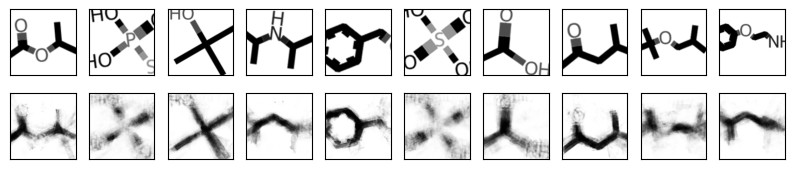

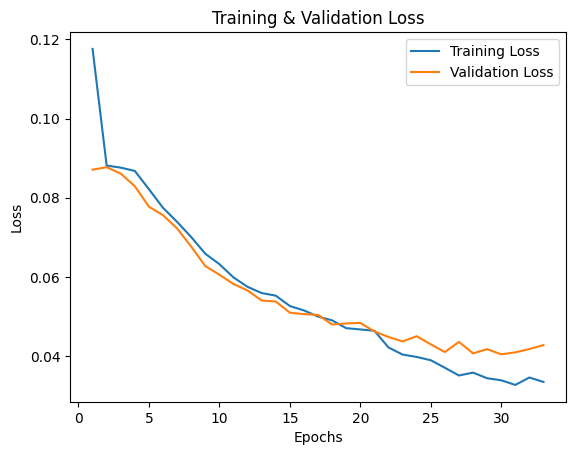

In [ ]:
show_resualts(autoencoder, X_test)
show_history(history)

In [ ]:
input_img = Input((img_size[0], img_size[1], 1))
x = Flatten()(input_img)
x = Dense(2048, activation = 'relu')(x)
x = Dense(1024, activation = 'relu')(x)
encoded = Dense(512, activation = 'relu')(x)

d = Dense(1024, activation = 'relu')(encoded)
d = Dense(img_size[0] * img_size[1], activation = 'sigmoid')(d)
decoded = Reshape((img_size[0], img_size[1], 1))(d)

autoencoder = keras.Model(input_img, decoded, name = "autoencoder")
autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
history = autoencoder.fit(X_train, X_train,
                epochs = 50,
                batch_size = batch_size,
                validation_data = (X_test, X_test),
                shuffle = True,
                callbacks = [early_stopping])

Epoch 1/50
28/28 [==============================] - 33s 1s/step - loss: 0.1067 - val_loss: 0.0866
Epoch 2/50
28/28 [==============================] - 31s 1s/step - loss: 0.0869 - val_loss: 0.0823
Epoch 3/50
28/28 [==============================] - 30s 1s/step - loss: 0.0787 - val_loss: 0.0736
Epoch 4/50
28/28 [==============================] - 30s 1s/step - loss: 0.0701 - val_loss: 0.0641
Epoch 5/50
28/28 [==============================] - 32s 1s/step - loss: 0.0626 - val_loss: 0.0583
Epoch 6/50
28/28 [==============================] - 30s 1s/step - loss: 0.0578 - val_loss: 0.0537
Epoch 7/50
28/28 [==============================] - 30s 1s/step - loss: 0.0546 - val_loss: 0.0506
Epoch 8/50
28/28 [==============================] - 31s 1s/step - loss: 0.0500 - val_loss: 0.0484
Epoch 9/50
28/28 [==============================] - 30s 1s/step - loss: 0.0464 - val_loss: 0.0466
Epoch 10/50
28/28 [==============================] - 30s 1s/step - loss: 0.0445 - val_loss: 0.0457
Epoch 11/50
28/28 [

1/1 [==============================] - 0s 141ms/step


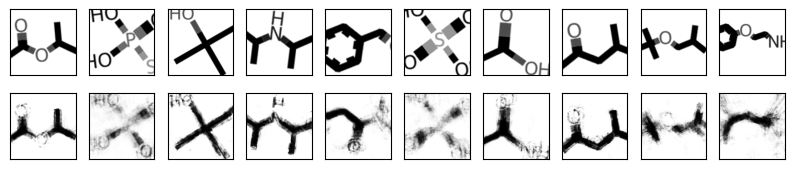

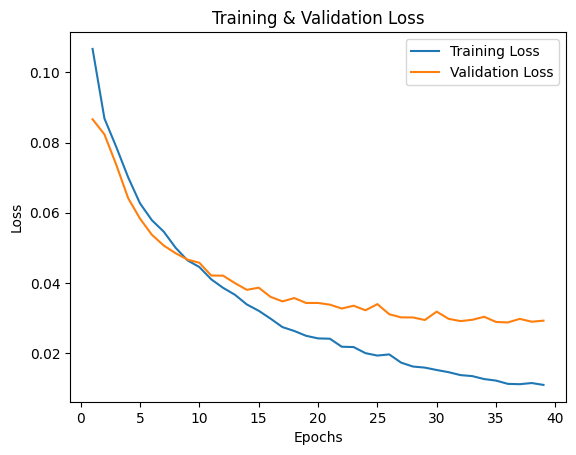

In [ ]:
show_resualts(autoencoder, X_test)
show_history(history)

In [ ]:
input_img = Input((img_size[0], img_size[1], 1))
x = Flatten()(input_img)
x = Dense(256, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
encoded = Dense(64, activation = 'relu')(x)

d = Dense(128, activation = 'relu')(encoded)
d = Dense(256, activation = 'relu')(d)
d = Dense(img_size[0] * img_size[1], activation = 'sigmoid')(d)
decoded = Reshape((img_size[0], img_size[1], 1))(d)

autoencoder = keras.Model(input_img, decoded, name = "autoencoder")
autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
history = autoencoder.fit(X_train, X_train,
                epochs = 200,
                batch_size = batch_size,
                validation_data = (X_test, X_test),
                shuffle = True,
                callbacks = [early_stopping])

Epoch 1/200
28/28 [==============================] - 5s 129ms/step - loss: 0.1090 - val_loss: 0.0866
Epoch 2/200
28/28 [==============================] - 4s 134ms/step - loss: 0.0863 - val_loss: 0.0812
Epoch 3/200
28/28 [==============================] - 4s 149ms/step - loss: 0.0779 - val_loss: 0.0717
Epoch 4/200
28/28 [==============================] - 3s 122ms/step - loss: 0.0707 - val_loss: 0.0654
Epoch 5/200
28/28 [==============================] - 4s 136ms/step - loss: 0.0630 - val_loss: 0.0584
Epoch 6/200
28/28 [==============================] - 5s 162ms/step - loss: 0.0583 - val_loss: 0.0549
Epoch 7/200
28/28 [==============================] - 4s 127ms/step - loss: 0.0556 - val_loss: 0.0518
Epoch 8/200
28/28 [==============================] - 4s 130ms/step - loss: 0.0519 - val_loss: 0.0496
Epoch 9/200
28/28 [==============================] - 5s 163ms/step - loss: 0.0494 - val_loss: 0.0480
Epoch 10/200
28/28 [==============================] - 3s 123ms/step - loss: 0.0460 - val_lo

1/1 [==============================] - 0s 110ms/step


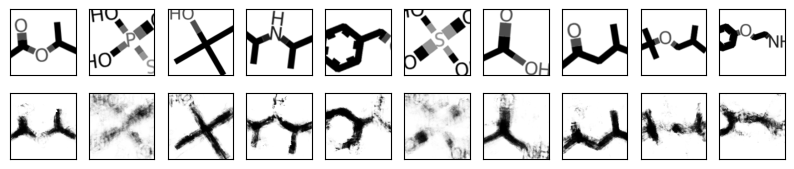

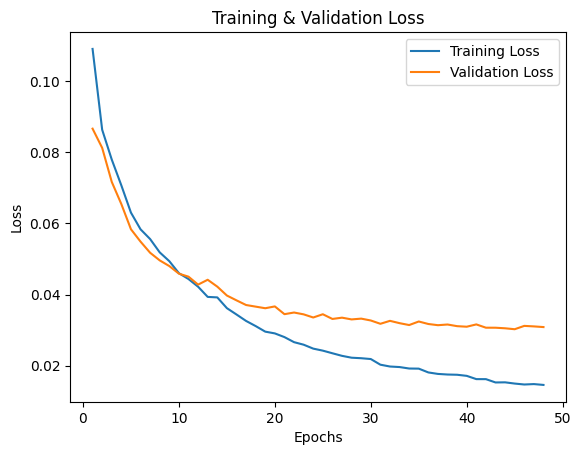

In [ ]:
show_resualts(autoencoder, X_test)
show_history(history)

In [ ]:
input_img = Input(shape = (img_size[0], img_size[1], 1))

x = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(input_img)
x = MaxPooling2D((2, 2), padding = 'same')(x)
x = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(x)
x = MaxPooling2D((2, 2), padding = 'same')(x)
x = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(x)
encoded = MaxPooling2D((2, 2), padding = 'same')(x)

d = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(encoded)
d = UpSampling2D((2, 2))(d)
d = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(d)
d = UpSampling2D((2, 2))(d)
d = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(d)
d = UpSampling2D((2, 2))(d)
decoded = Conv2D(1, (3, 3), activation = 'sigmoid', padding = 'same')(d)

autoencoder = keras.Model(input_img, decoded, name = 'autoencoder')
autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
history = autoencoder.fit(X_train, X_train,
                epochs = 25,
                batch_size = batch_size,
                validation_data = (X_test, X_test),
                shuffle = True,
                callbacks = [early_stopping])

Epoch 1/25
28/28 [==============================] - 35s 1s/step - loss: 0.1225 - val_loss: 0.0509
Epoch 2/25
28/28 [==============================] - 33s 1s/step - loss: 0.0300 - val_loss: 0.0194
Epoch 3/25
28/28 [==============================] - 36s 1s/step - loss: 0.0150 - val_loss: 0.0127
Epoch 4/25
28/28 [==============================] - 39s 1s/step - loss: 0.0110 - val_loss: 0.0099
Epoch 5/25
28/28 [==============================] - 32s 1s/step - loss: 0.0091 - val_loss: 0.0094
Epoch 6/25
28/28 [==============================] - 34s 1s/step - loss: 0.0081 - val_loss: 0.0076
Epoch 7/25
28/28 [==============================] - 32s 1s/step - loss: 0.0071 - val_loss: 0.0071
Epoch 8/25
28/28 [==============================] - 33s 1s/step - loss: 0.0067 - val_loss: 0.0067
Epoch 9/25
28/28 [==============================] - 32s 1s/step - loss: 0.0064 - val_loss: 0.0062
Epoch 10/25
28/28 [==============================] - 34s 1s/step - loss: 0.0059 - val_loss: 0.0061
Epoch 11/25
28/28 [

1/1 [==============================] - 1s 515ms/step


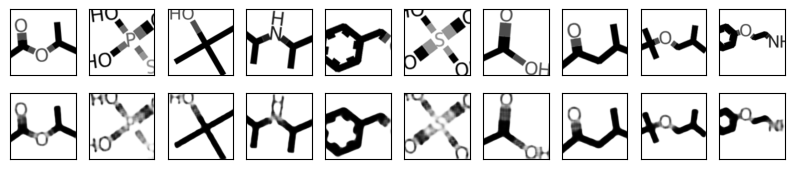

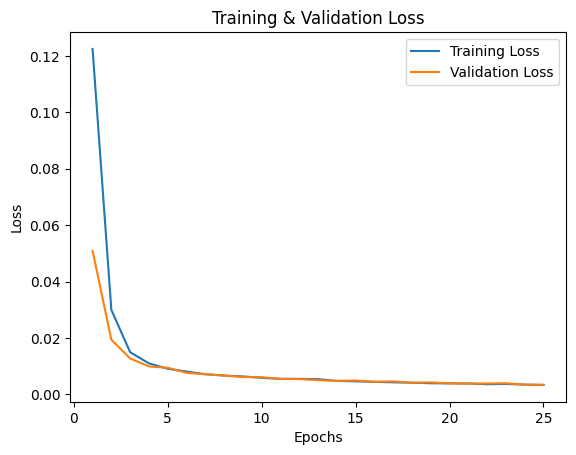

In [ ]:
show_resualts(autoencoder, X_test)
show_history(history)

In [ ]:
input_img = Input(shape = (img_size[0], img_size[1], 1))

x = Conv2D(16, (5, 5), activation = 'relu', padding = 'same')(input_img)
x = MaxPooling2D((2, 2), padding = 'same')(x)
x = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(x)
x = MaxPooling2D((2, 2), padding = 'same')(x)
x = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(x)
encoded = MaxPooling2D((2, 2), padding = 'same')(x)

d = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(encoded)
d = UpSampling2D((2, 2))(d)
d = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(d)
d = UpSampling2D((2, 2))(d)
d = Conv2D(16, (5, 5), activation = 'relu', padding = 'same')(d)
d = UpSampling2D((2, 2))(d)
decoded = Conv2D(1, (3, 3), activation = 'sigmoid', padding = 'same')(d)

autoencoder = keras.Model(input_img, decoded, name = 'autoencoder')
autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
history = autoencoder.fit(X_train, X_train,
                epochs = 25,
                batch_size = batch_size,
                validation_data = (X_test, X_test),
                shuffle = True,
                callbacks = [early_stopping])

Epoch 1/25
28/28 [==============================] - 48s 2s/step - loss: 0.1092 - val_loss: 0.0532
Epoch 2/25
28/28 [==============================] - 47s 2s/step - loss: 0.0303 - val_loss: 0.0197
Epoch 3/25
28/28 [==============================] - 46s 2s/step - loss: 0.0167 - val_loss: 0.0141
Epoch 4/25
28/28 [==============================] - 46s 2s/step - loss: 0.0127 - val_loss: 0.0116
Epoch 5/25
28/28 [==============================] - 45s 2s/step - loss: 0.0099 - val_loss: 0.0092
Epoch 6/25
28/28 [==============================] - 46s 2s/step - loss: 0.0081 - val_loss: 0.0085
Epoch 7/25
28/28 [==============================] - 45s 2s/step - loss: 0.0071 - val_loss: 0.0068
Epoch 8/25
28/28 [==============================] - 47s 2s/step - loss: 0.0065 - val_loss: 0.0062
Epoch 9/25
28/28 [==============================] - 45s 2s/step - loss: 0.0058 - val_loss: 0.0057
Epoch 10/25
28/28 [==============================] - 46s 2s/step - loss: 0.0054 - val_loss: 0.0054
Epoch 11/25
28/28 [

1/1 [==============================] - 0s 204ms/step


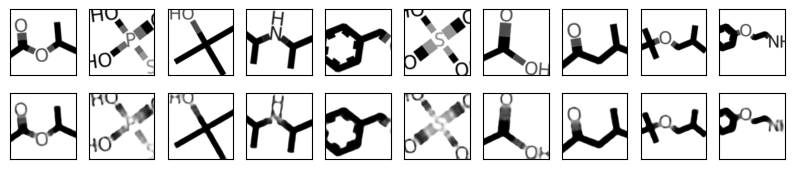

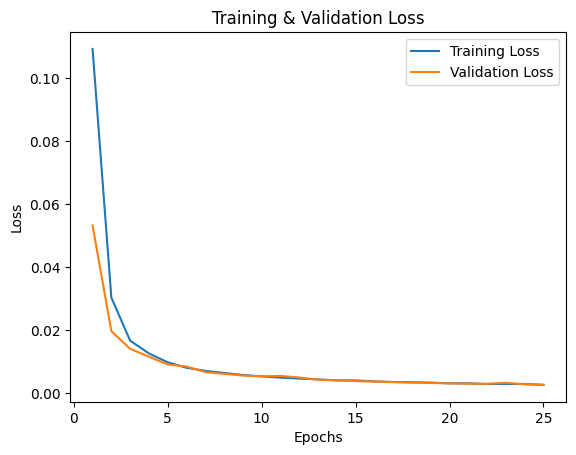

In [ ]:
show_resualts(autoencoder, X_test)
show_history(history)

In [ ]:
input_img = Input(shape = (img_size[0], img_size[1], 1))

x = Conv2D(16, (5, 5), activation = 'relu', padding = 'same')(input_img)
x = MaxPooling2D((2, 2), padding = 'same')(x)
x = Conv2D(32, (5, 5), activation = 'relu', padding = 'same')(x)
x = MaxPooling2D((2, 2), padding = 'same')(x)
x = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(x)
encoded = MaxPooling2D((2, 2), padding = 'same')(x)

d = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(encoded)
d = UpSampling2D((2, 2))(d)
d = Conv2D(32, (5, 5), activation = 'relu', padding = 'same')(d)
d = UpSampling2D((2, 2))(d)
d = Conv2D(16, (5, 5), activation = 'relu', padding = 'same')(d)
d = UpSampling2D((2, 2))(d)
decoded = Conv2D(1, (3, 3), activation = 'sigmoid', padding = 'same')(d)

autoencoder = keras.Model(input_img, decoded, name = 'autoencoder')
autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
history = autoencoder.fit(X_train, X_train,
                epochs = 25,
                batch_size = batch_size,
                validation_data = (X_test, X_test),
                shuffle = True,
                callbacks = [early_stopping])

Epoch 1/25
28/28 [==============================] - 59s 2s/step - loss: 0.1130 - val_loss: 0.0549
Epoch 2/25
28/28 [==============================] - 77s 3s/step - loss: 0.0289 - val_loss: 0.0171
Epoch 3/25
28/28 [==============================] - 57s 2s/step - loss: 0.0151 - val_loss: 0.0131
Epoch 4/25
28/28 [==============================] - 56s 2s/step - loss: 0.0111 - val_loss: 0.0105
Epoch 5/25
28/28 [==============================] - 58s 2s/step - loss: 0.0090 - val_loss: 0.0085
Epoch 6/25
28/28 [==============================] - 55s 2s/step - loss: 0.0077 - val_loss: 0.0075
Epoch 7/25
28/28 [==============================] - 56s 2s/step - loss: 0.0070 - val_loss: 0.0066
Epoch 8/25
28/28 [==============================] - 58s 2s/step - loss: 0.0064 - val_loss: 0.0061
Epoch 9/25
28/28 [==============================] - 55s 2s/step - loss: 0.0057 - val_loss: 0.0055
Epoch 10/25
28/28 [==============================] - 55s 2s/step - loss: 0.0052 - val_loss: 0.0052
Epoch 11/25
28/28 [

1/1 [==============================] - 0s 249ms/step


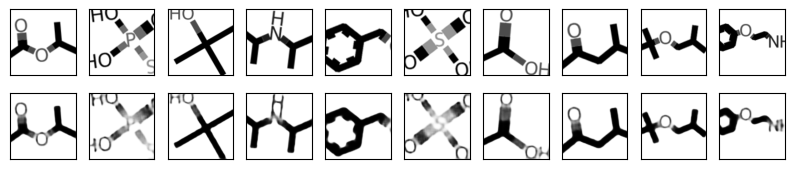

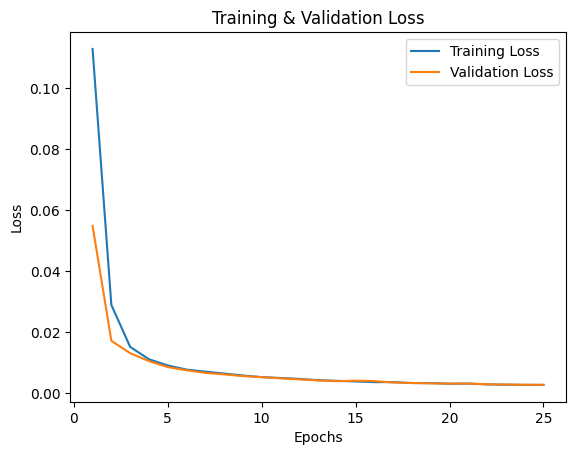

In [ ]:
show_resualts(autoencoder, X_test)
show_history(history)

In [ ]:
input_img = Input(shape = (img_size[0], img_size[1], 1))

x = Conv2D(16, (5, 5), activation = 'relu', padding = 'same')(input_img)
x = MaxPooling2D((2, 2), padding = 'same')(x)
x = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(x)
x = MaxPooling2D((2, 2), padding = 'same')(x)
x = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(x)
encoded = MaxPooling2D((2, 2), padding = 'same')(x)

d = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(encoded)
d = UpSampling2D((2, 2))(d)
d = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(d)
d = UpSampling2D((2, 2))(d)
d = Conv2D(16, (5, 5), activation = 'relu', padding = 'same')(d)
d = UpSampling2D((2, 2))(d)
decoded = Conv2D(1, (3, 3), activation = 'sigmoid', padding = 'same')(d)

autoencoder = keras.Model(input_img, decoded, name = 'autoencoder')
autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
history = autoencoder.fit(X_train, X_train,
                epochs = 50,
                batch_size = batch_size,
                validation_data = (X_test, X_test),
                shuffle = True,
                callbacks = [early_stopping])

Epoch 1/50
28/28 [==============================] - 55s 2s/step - loss: 0.1212 - val_loss: 0.0656
Epoch 2/50
28/28 [==============================] - 46s 2s/step - loss: 0.0379 - val_loss: 0.0187
Epoch 3/50
28/28 [==============================] - 48s 2s/step - loss: 0.0158 - val_loss: 0.0127
Epoch 4/50
28/28 [==============================] - 49s 2s/step - loss: 0.0109 - val_loss: 0.0108
Epoch 5/50
28/28 [==============================] - 48s 2s/step - loss: 0.0092 - val_loss: 0.0091
Epoch 6/50
28/28 [==============================] - 46s 2s/step - loss: 0.0079 - val_loss: 0.0076
Epoch 7/50
28/28 [==============================] - 44s 2s/step - loss: 0.0070 - val_loss: 0.0068
Epoch 8/50
28/28 [==============================] - 44s 2s/step - loss: 0.0065 - val_loss: 0.0062
Epoch 9/50
28/28 [==============================] - 45s 2s/step - loss: 0.0058 - val_loss: 0.0061
Epoch 10/50
28/28 [==============================] - 43s 2s/step - loss: 0.0054 - val_loss: 0.0055
Epoch 11/50
28/28 [

1/1 [==============================] - 0s 249ms/step


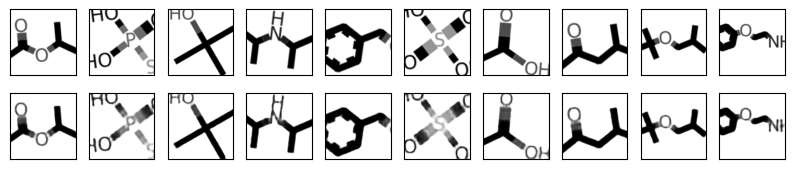

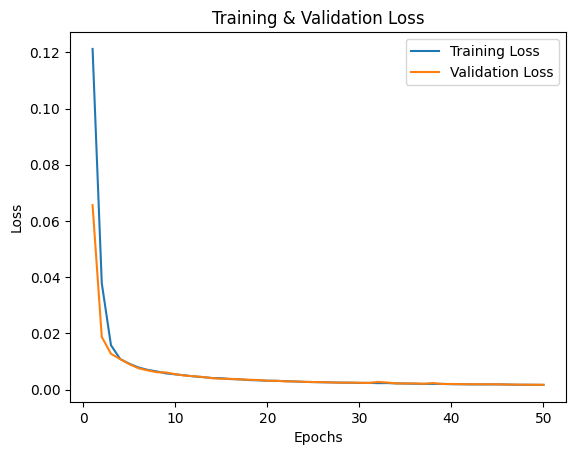

In [ ]:
show_resualts(autoencoder, X_test)
show_history(history)

In [ ]:
X_train, X_test = train_test_split(images, train_size = 0.8, random_state = 42)

X_train = np.array([np.array(i) for i in X_train])
X_train = X_train / 255.0
X_train = np.reshape(X_train, (len(X_train), img_size[0], img_size[1], 3))

X_test = np.array([np.array(i) for i in X_test])
X_test = X_test / 255.0
X_test = np.reshape(X_test, (len(X_test), img_size[0], img_size[1], 3))

In [ ]:
input_img = Input(shape = (img_size[0], img_size[1], 3))

x = Conv2D(16, (5, 5), activation = 'relu', padding = 'same')(input_img)
x = MaxPooling2D((2, 2), padding = 'same')(x)
x = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(x)
x = MaxPooling2D((2, 2), padding = 'same')(x)
x = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(x)
encoded = MaxPooling2D((2, 2), padding = 'same')(x)

d = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(encoded)
d = UpSampling2D((2, 2))(d)
d = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(d)
d = UpSampling2D((2, 2))(d)
d = Conv2D(16, (5, 5), activation = 'relu', padding = 'same')(d)
d = UpSampling2D((2, 2))(d)
decoded = Conv2D(3, (3, 3), activation = 'sigmoid', padding = 'same')(d)

autoencoder = keras.Model(input_img, decoded, name = 'autoencoder')
autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
history = autoencoder.fit(X_train, X_train,
                epochs = 50,
                batch_size = batch_size,
                validation_data = (X_test, X_test),
                shuffle = True,
                callbacks = [early_stopping])

Epoch 1/50
28/28 [==============================] - 51s 2s/step - loss: 0.1239 - val_loss: 0.0965
Epoch 2/50
28/28 [==============================] - 50s 2s/step - loss: 0.0775 - val_loss: 0.0497
Epoch 3/50
28/28 [==============================] - 48s 2s/step - loss: 0.0374 - val_loss: 0.0265
Epoch 4/50
28/28 [==============================] - 49s 2s/step - loss: 0.0211 - val_loss: 0.0186
Epoch 5/50
28/28 [==============================] - 52s 2s/step - loss: 0.0162 - val_loss: 0.0142
Epoch 6/50
28/28 [==============================] - 49s 2s/step - loss: 0.0137 - val_loss: 0.0128
Epoch 7/50
28/28 [==============================] - 52s 2s/step - loss: 0.0111 - val_loss: 0.0102
Epoch 8/50
28/28 [==============================] - 56s 2s/step - loss: 0.0093 - val_loss: 0.0088
Epoch 9/50
28/28 [==============================] - 73s 3s/step - loss: 0.0086 - val_loss: 0.0084
Epoch 10/50
28/28 [==============================] - 50s 2s/step - loss: 0.0077 - val_loss: 0.0072
Epoch 11/50
28/28 [

1/1 [==============================] - 0s 245ms/step


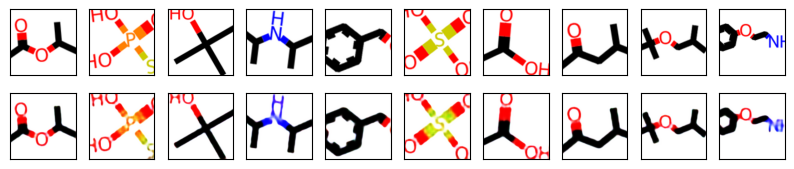

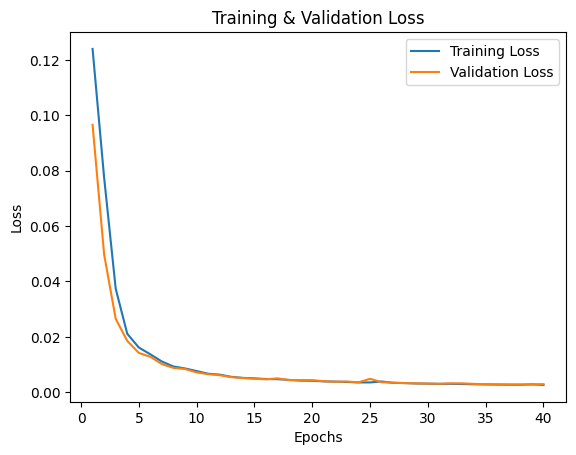

In [ ]:
show_RGBresualts(autoencoder, X_test)
show_history(history)

In [ ]:
input_img = Input(shape = (img_size[0], img_size[1], 3))

x = Conv2D(16, (5, 5), activation = 'relu', padding = 'same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding = 'same')(x)
x = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding = 'same')(x)
x = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
encoded_ = MaxPooling2D((2, 2), padding = 'same')(x)

d = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(encoded_)
d = BatchNormalization()(d)
d = UpSampling2D((2, 2))(d)
d = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(d)
d = BatchNormalization()(d)
d = UpSampling2D((2, 2))(d)
d = Conv2D(16, (5, 5), activation = 'relu', padding = 'same')(d)
d = BatchNormalization()(d)
d = UpSampling2D((2, 2))(d)
decoded_ = Conv2D(3, (3, 3), activation = 'sigmoid', padding = 'same')(d)

autoencoder_ = keras.Model(input_img, decoded_, name = 'autoencoder')
autoencoder_.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
history = autoencoder_.fit(X_train, X_train,
                epochs = 50,
                batch_size = batch_size,
                validation_data = (X_test, X_test),
                shuffle = True,
                callbacks = [early_stopping])

Epoch 1/50
28/28 [==============================] - 68s 2s/step - loss: 0.1137 - val_loss: 0.1231
Epoch 2/50
28/28 [==============================] - 55s 2s/step - loss: 0.0374 - val_loss: 0.1117
Epoch 3/50
28/28 [==============================] - 56s 2s/step - loss: 0.0188 - val_loss: 0.1116
Epoch 4/50
28/28 [==============================] - 57s 2s/step - loss: 0.0129 - val_loss: 0.0867
Epoch 5/50
28/28 [==============================] - 57s 2s/step - loss: 0.0101 - val_loss: 0.0620
Epoch 6/50
28/28 [==============================] - 56s 2s/step - loss: 0.0089 - val_loss: 0.0522
Epoch 7/50
28/28 [==============================] - 68s 2s/step - loss: 0.0076 - val_loss: 0.0456
Epoch 8/50
28/28 [==============================] - 57s 2s/step - loss: 0.0067 - val_loss: 0.0377
Epoch 9/50
28/28 [==============================] - 55s 2s/step - loss: 0.0061 - val_loss: 0.0328
Epoch 10/50
28/28 [==============================] - 55s 2s/step - loss: 0.0061 - val_loss: 0.0273
Epoch 11/50
28/28 [

1/1 [==============================] - 1s 534ms/step


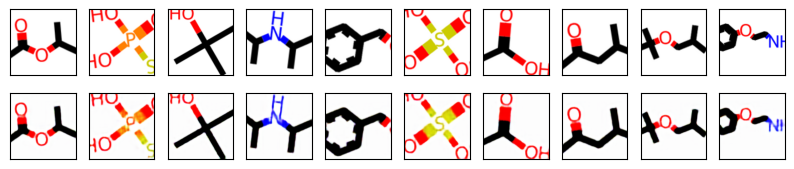

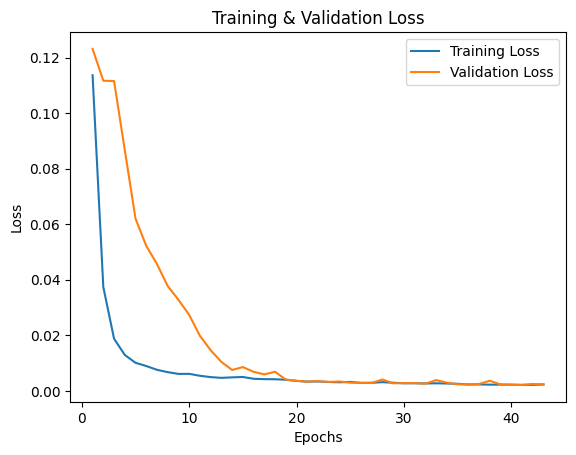

In [ ]:
show_RGBresualts(autoencoder_, X_test)
show_history(history)

1/1 [==============================] - 1s 1s/step


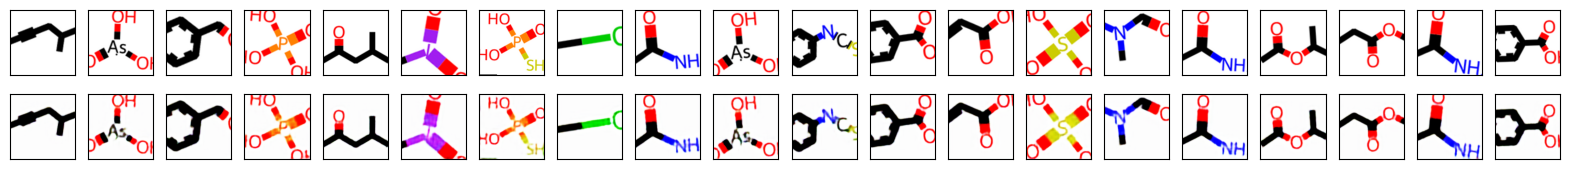

In [ ]:
n = 20

imgs = X_test[10 : 30]
decoded_imgs = autoencoder_.predict(X_test[10 : 30], batch_size = n)

plt.figure(figsize = (n, 2))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(imgs[i].squeeze())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax2 = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].squeeze())
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)

plt.show()

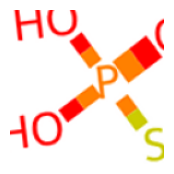

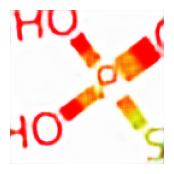

1/1 [==============================] - 1s 572ms/step


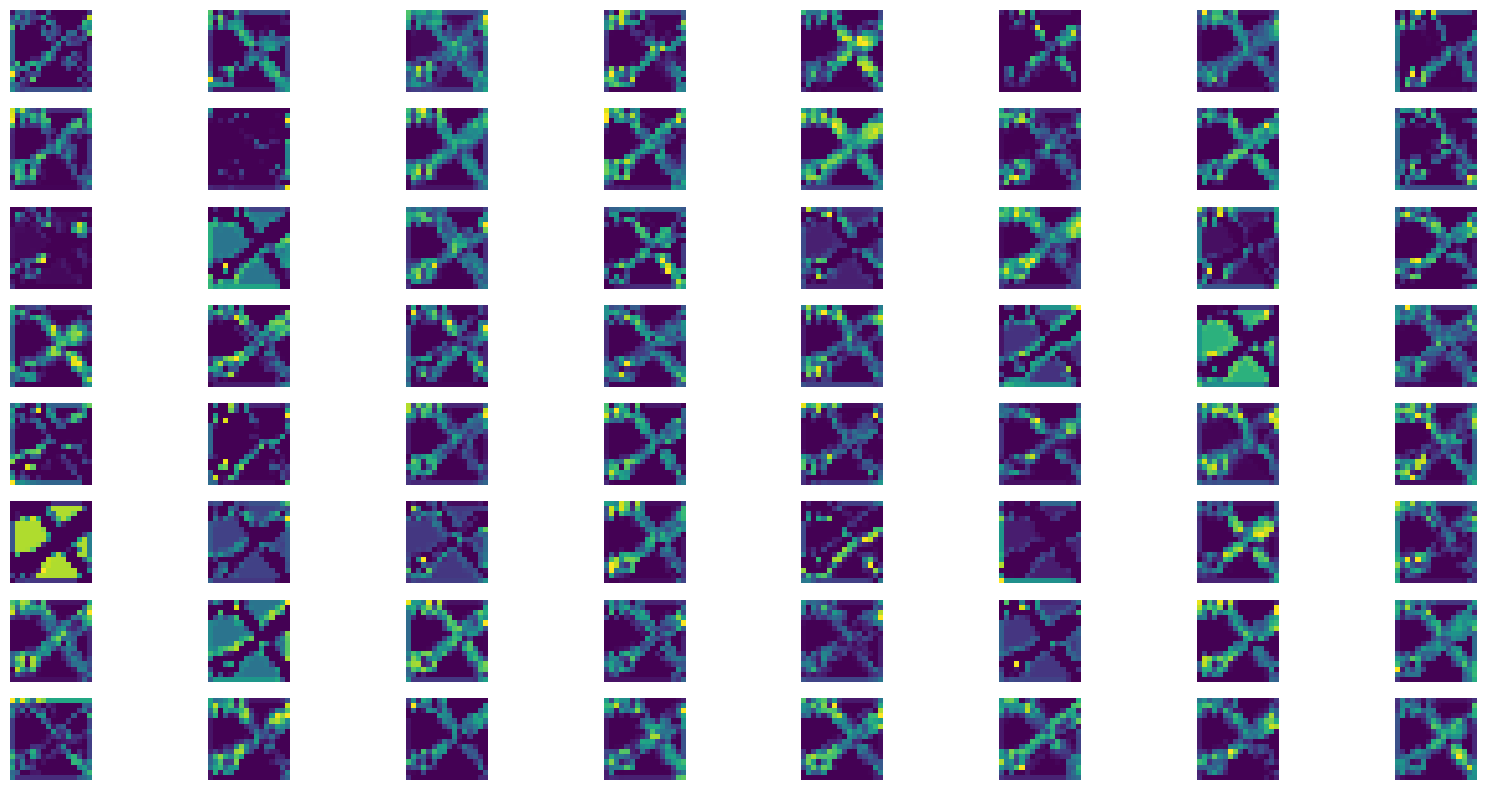

In [ ]:
encoder_model = Model(inputs = input_img, outputs = encoded_)

to_show = 1

image = X_test[to_show]

plt.figure(figsize = (2, 2))
plt.imshow(image)
plt.axis('off')
plt.show()

predicted_image = autoencoder_(X_test[:20])
plt.figure(figsize = (2, 2))
plt.imshow(predicted_image[to_show], cmap = 'viridis')
plt.axis('off')
plt.show()

encoded_images = encoder_model.predict(X_test[:20])

num_channels = encoded_images.shape[3]
num_rows = 8
num_columns = num_channels // num_rows

plt.figure(figsize = (20, 10))

for i in range(num_channels):
    ax = plt.subplot(num_rows, num_columns, i + 1)
    plt.imshow(encoded_images[to_show, :, :, i], cmap = 'viridis')
    plt.axis('off')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [ ]:
input_img = Input(shape = (img_size[0], img_size[1], 3))

x = Conv2D(64, (5, 5), activation = 'relu', padding = 'same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding = 'same')(x)
x = Conv2D(48, (3, 3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding = 'same')(x)
x = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
encoded_ = MaxPooling2D((2, 2), padding = 'same')(x)

d = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(encoded_)
d = BatchNormalization()(d)
d = UpSampling2D((2, 2))(d)
d = Conv2D(48, (3, 3), activation = 'relu', padding = 'same')(d)
d = BatchNormalization()(d)
d = UpSampling2D((2, 2))(d)
d = Conv2D(16, (5, 5), activation = 'relu', padding = 'same')(d)
d = BatchNormalization()(d)
d = UpSampling2D((2, 2))(d)
decoded_ = Conv2D(3, (3, 3), activation = 'sigmoid', padding = 'same')(d)

autoencoder_ = keras.Model(input_img, decoded_, name = 'autoencoder')
autoencoder_.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
history = autoencoder_.fit(X_train, X_train,
                epochs = 50,
                batch_size = batch_size,
                validation_data = (X_test, X_test),
                shuffle = True,
                callbacks = [early_stopping])

Epoch 1/50
28/28 [==============================] - 105s 4s/step - loss: 0.1156 - val_loss: 0.1169
Epoch 2/50
28/28 [==============================] - 97s 3s/step - loss: 0.0399 - val_loss: 0.1110
Epoch 3/50
28/28 [==============================] - 98s 3s/step - loss: 0.0202 - val_loss: 0.0984
Epoch 4/50
28/28 [==============================] - 97s 3s/step - loss: 0.0143 - val_loss: 0.0717
Epoch 5/50
28/28 [==============================] - 99s 4s/step - loss: 0.0113 - val_loss: 0.0531
Epoch 6/50
28/28 [==============================] - 102s 4s/step - loss: 0.0097 - val_loss: 0.0418
Epoch 7/50
28/28 [==============================] - 97s 3s/step - loss: 0.0086 - val_loss: 0.0353
Epoch 8/50
28/28 [==============================] - 98s 3s/step - loss: 0.0075 - val_loss: 0.0304
Epoch 9/50
28/28 [==============================] - 104s 4s/step - loss: 0.0069 - val_loss: 0.0249
Epoch 10/50
28/28 [==============================] - 96s 3s/step - loss: 0.0064 - val_loss: 0.0229
Epoch 11/50
28/2

1/1 [==============================] - 0s 425ms/step


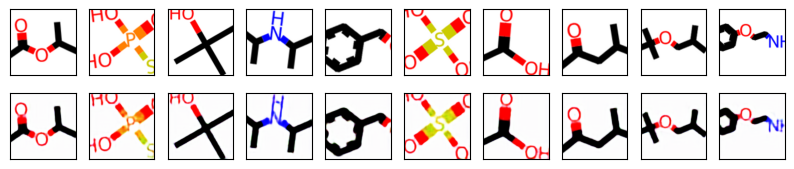

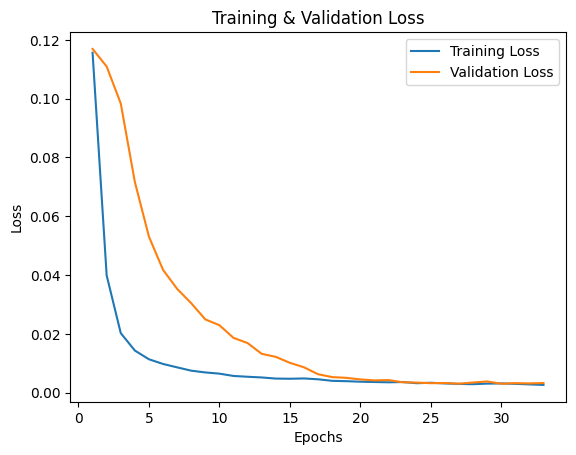

In [ ]:
show_RGBresualts(autoencoder_, X_test)
show_history(history)

1/1 [==============================] - 5s 5s/step


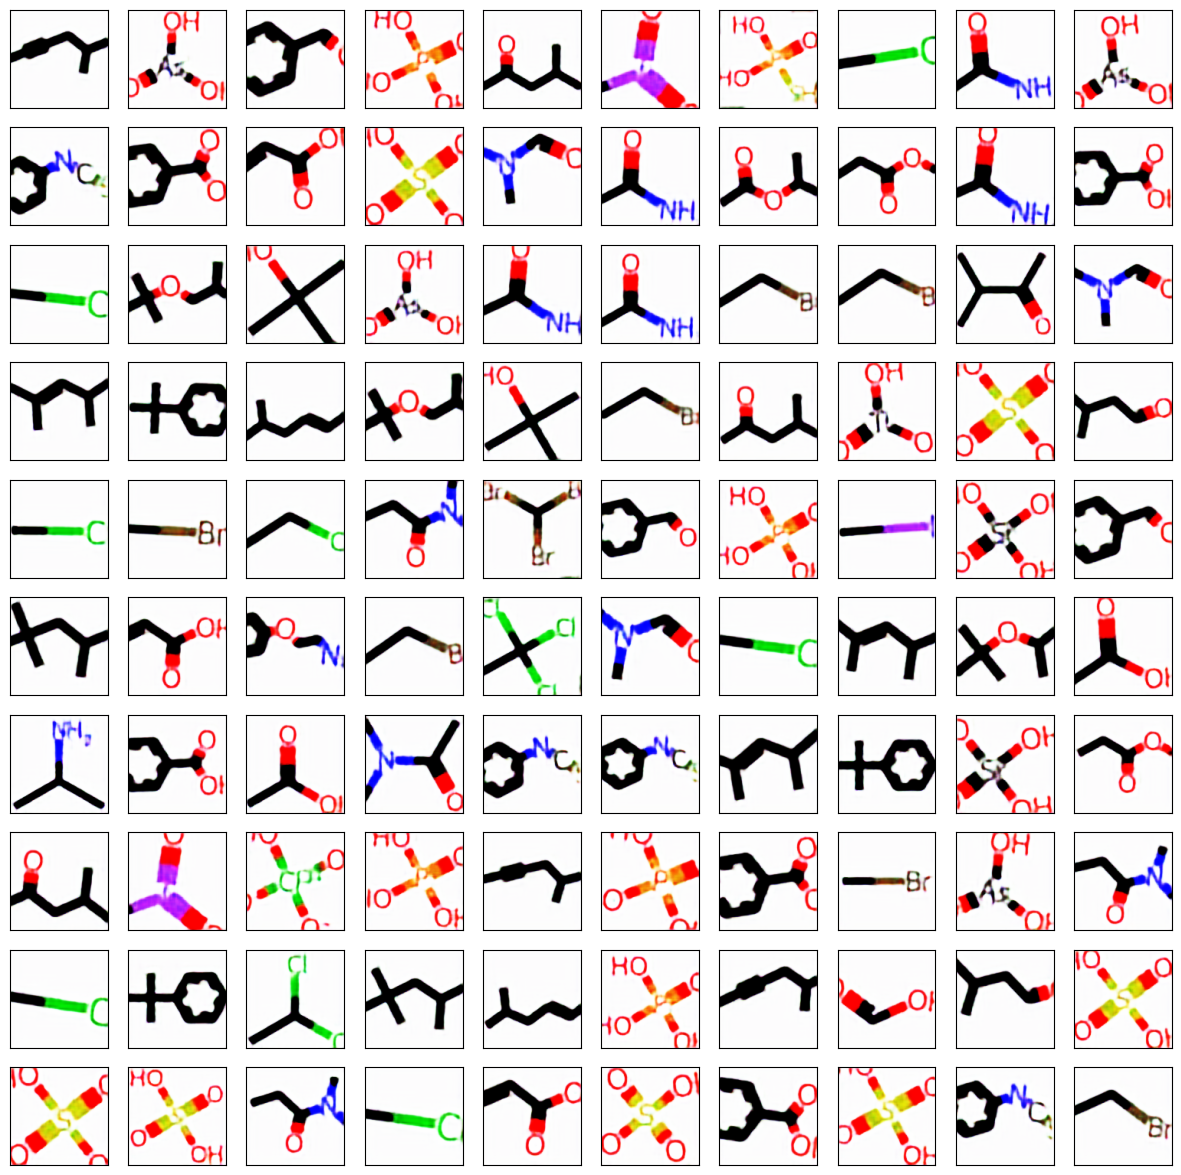

In [173]:
n = 100

imgs = X_test[10 : 110]
decoded_imgs = autoencoder_.predict(X_test[10 : 110], batch_size = n)

plt.figure(figsize = (15, 15))
for i in range(n):
    ax2 = plt.subplot(10, 10, i + 1)
    plt.imshow(decoded_imgs[i].squeeze())
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)

plt.show()

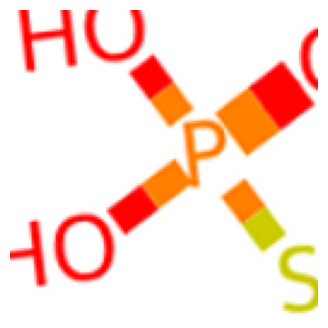

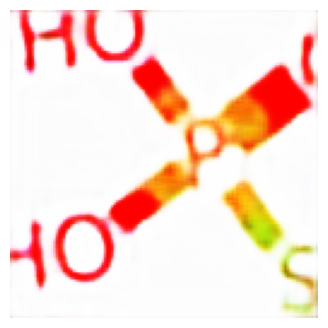

1/1 [==============================] - 1s 956ms/step


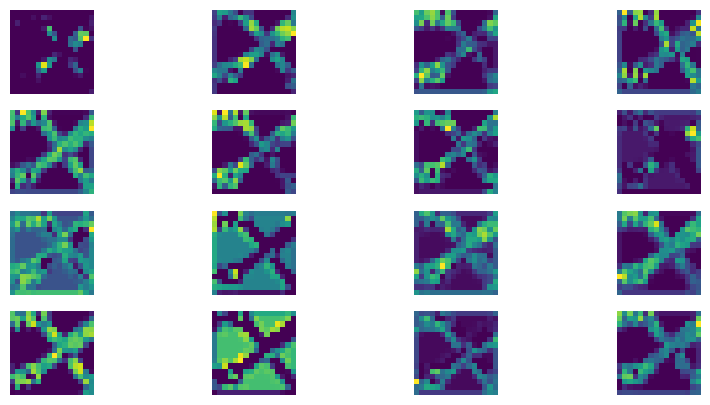

(16, 16, 16)


In [169]:
encoder_model = Model(inputs = input_img, outputs = encoded_)

to_show = 1

image = X_test[to_show]

plt.figure(figsize = (4, 4))
plt.imshow(image)
plt.axis('off')
plt.show()

predicted_image = autoencoder_(X_test[:20])
plt.figure(figsize = (4, 4))
plt.imshow(predicted_image[to_show], cmap = 'viridis')
plt.axis('off')
plt.show()

encoded_images = encoder_model.predict(X_test[:20])

num_channels = encoded_images.shape[3]
num_rows = 4
num_columns = num_channels // num_rows

plt.figure(figsize = (10, 5))

for i in range(num_channels):
    ax = plt.subplot(num_rows, num_columns, i + 1)
    plt.imshow(encoded_images[to_show, :, :, i], cmap = 'viridis')
    plt.axis('off')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

print(encoded_images[1].shape)

(-0.5, 127.5, 127.5, -0.5)

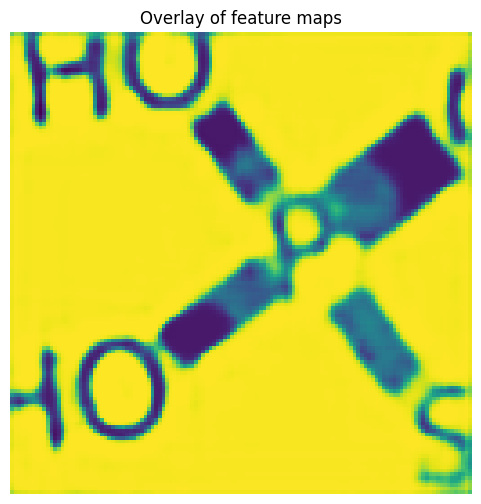

In [ ]:
overlay = np.sum(predicted_image[to_show], axis = 2)
plt.figure(figsize = (6, 6))
plt.imshow(overlay, cmap = 'viridis')
plt.title("Overlay of feature maps")
plt.axis('off')

(-0.5, 127.5, 127.5, -0.5)

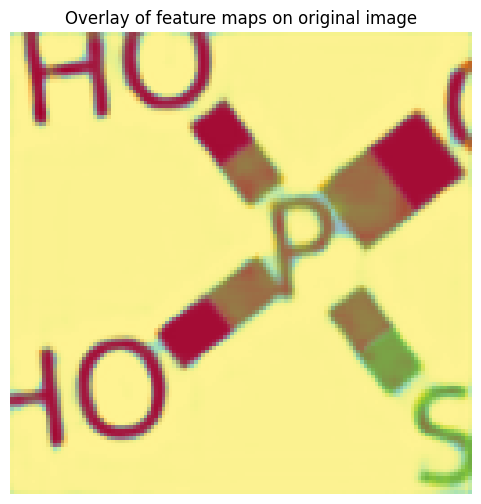

In [168]:
overlay = np.sum(predicted_image[to_show], axis = 2)
plt.figure(figsize = (6, 6))
plt.imshow(image, cmap = 'gray')
plt.imshow(overlay, cmap = 'viridis', alpha = 0.5)
plt.title("Overlay of feature maps on original image")
plt.axis('off')